# Content Analysis

In [1]:
import arviz as az
import bambi as bmb
#from bambi.plots import plot_cap
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_json('data/year_predictions.json')
df['image_id'] = np.random.permutation(len(df))

# adding paths
df2 = pd.read_json('data/image_data.json')
df['paths'] = df2[0]

# calculating error rate
df['error_bw'] = df['actual_year'] - df['year_pred']
df['error_bw_abs'] = df['error_bw'].abs()


In [3]:
df.columns

Index(['year_pred', 'year_colorized_pred', 'actual_year', 'n_people', 'scene',
       'train_test', 'objects', 'image_id', 'paths', 'error_bw',
       'error_bw_abs'],
      dtype='object')

airplane, 

<Axes: title={'center': 'distribution of absolute error'}, ylabel='Frequency'>

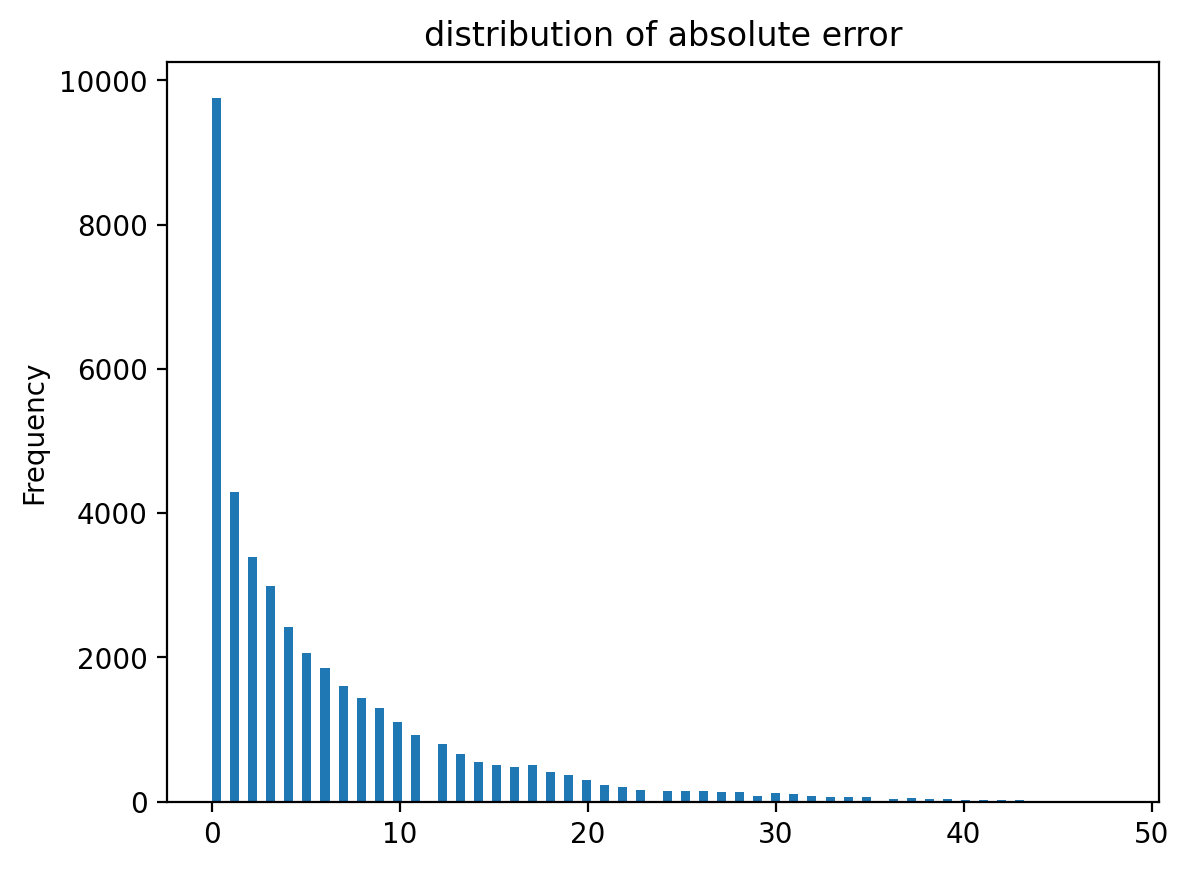

In [4]:
df['error_bw_abs'].plot.hist(bins=100, title='distribution of absolute error')

In [5]:
df['error_rate'] = df['error_bw_abs'] / (df['error_bw_abs'].max() - df['error_bw_abs'].min())

In [6]:
# add cut-off to confidence score for object detection
confidence = 0.8
df['objects'] = df['objects'].apply(lambda x: [item for item in x if item[1] >= confidence])

# only keep object names and remove confidence scores
df['objects'] = df['objects'].apply(lambda x: [sublist[0] for sublist in x if len(sublist) > 0]).tolist()

In [7]:
# dummy-encode labels
mlb = MultiLabelBinarizer()

encoded_array = mlb.fit_transform(df['objects'])
encoded_df = pd.DataFrame(encoded_array, columns=mlb.classes_)
encoded_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

for col in encoded_df.columns:
    encoded_df[col] = encoded_df[col].astype('category')
df = pd.concat([df.drop('objects', axis=1), encoded_df], axis=1)


In [8]:
result = ' + '.join(encoded_df.columns)
    

<Axes: >

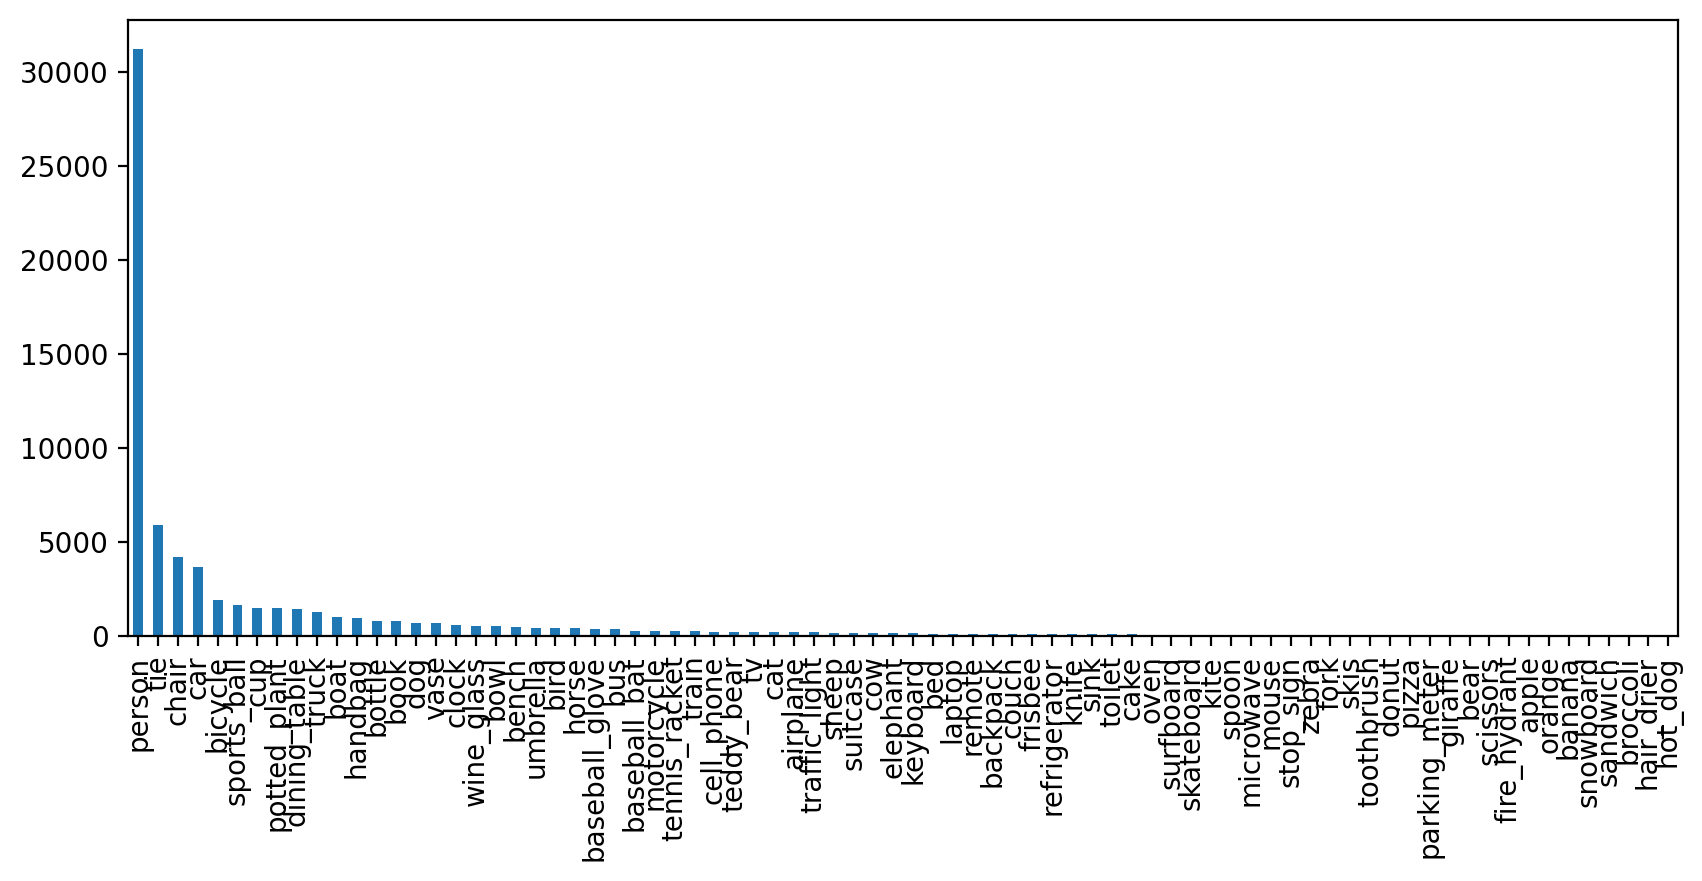

In [9]:
column_counts = encoded_df.eq(1).sum()
column_counts.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))


In [10]:
import sys
!{sys.executable} -m pip install ydata-profiling

In [11]:
from ydata_profiling import ProfileReport

In [12]:
profile = ProfileReport(df, title="Profiling Report")

In [ ]:
df['handbag']

In [142]:
df[df['wine_glass'] == 1]['scene'].value_counts()

scene
ceremony               103
dining_area             81
portrait                73
group_portrait          62
bar                     54
meeting_room            26
welcome_goodbye         19
speech                  15
musical_performance     12
saint_niclaus           11
market                   9
shop_interior            8
maquette                 6
wedding                  5
living_room              5
kitchen                  5
dancing                  5
office                   4
exhibition               4
clergy                   4
carnaval                 3
crowd                    3
chess_checkers           3
boat_deck                2
theatre                  2
sports_misc              2
artwork                  2
patio                    2
statue                   1
horse                    1
classroom                1
soccer_team              1
basketball               1
baseball                 1
ice_skating              1
auditorium               1
marial_arts           

In [13]:
# selected_columns = []
# for column in encoded_df.columns:
#     if column in selected_labels.keys():
#         selected_columns.append(column)
# result = ' + '.join(selected_columns)   

In [18]:
# only select labels that fit within these three categories, excluding sub-labels
transportation = ['bicycle', 'boat', 'bus', 'car', 'motorcycle', 'train', 'truck']
animals = ['bird', 'cat', 'dog', 'horse']
person = ['person']

selected_columns = transportation + animals + person

In [19]:
# print strings for easy copy-pasting into model definition, as f'string will not work

In [20]:
' + '.join(selected_columns)

'bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person'

In [21]:
', '.join(['"{}"'.format(item) for item in selected_columns])

'"bicycle", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"'

## Modeling

In [15]:
#Zero-inflated negative binomial

from bambi.families.univariate import UnivariateFamily

class ZeroInflatedBinomial(UnivariateFamily):
    SUPPORTED_LINKS = {
        "p": ["identity", "logit", "probit", "cloglog"],
        "psi": ["logit", "probit", "cloglog"]
    }

    @staticmethod
    def transform_backend_kwargs(kwargs):
        observed = kwargs.pop("observed")
        kwargs["observed"] = observed[:, 0].squeeze()
        kwargs["n"] = observed[:, 1].squeeze()
        return kwargs


    
likelihood = bmb.Likelihood("ZeroInflatedBinomial", params=["p", "psi"], parent="p")
links = {"p": "logit", "psi": "logit"}
zinb_family = ZeroInflatedBinomial("zinb", likelihood, links)
zinb_family



Family: zinb
Likelihood: Likelihood(  
  name: ZeroInflatedBinomial,
  params: ['p', 'psi'],
  parent: p,
  dist: None
)
Link: {'p': Link(  
  name: logit,
  link: <function logit at 0x7fe07a405cf0>,
  linkinv: <function expit at 0x7fe07a405c60>
), 'psi': Link(  
  name: logit,
  link: <function logit at 0x7fe07a405cf0>,
  linkinv: <function expit at 0x7fe07a405c60>
)}

In [24]:
from bambi import Prior

priors = {"psi": Prior('Beta', alpha=1, beta=1)}


### Zero Inflated Poisson

Initially, I decided to model this as counts. However, as reviewer 3 rightly pointed out, it might be better not to view this as a Poisson. I tried to approach it as a zero-inflated beta using error rates, but I ended up using beta using the absolute error rates. Also since the mean and variance were very different, violating one of the assumptions for a Poisson distribution.

In [27]:
model = bmb.Model(f'error_bw_abs ~ 1 + book', 
                        df, 
                        family='zero_inflated_binomial')

In [28]:
# # Fit the model using 1000 on each of 4 chains
results = model.fit(draws=2500, chains=4, inference_method='nuts_numpyro')



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

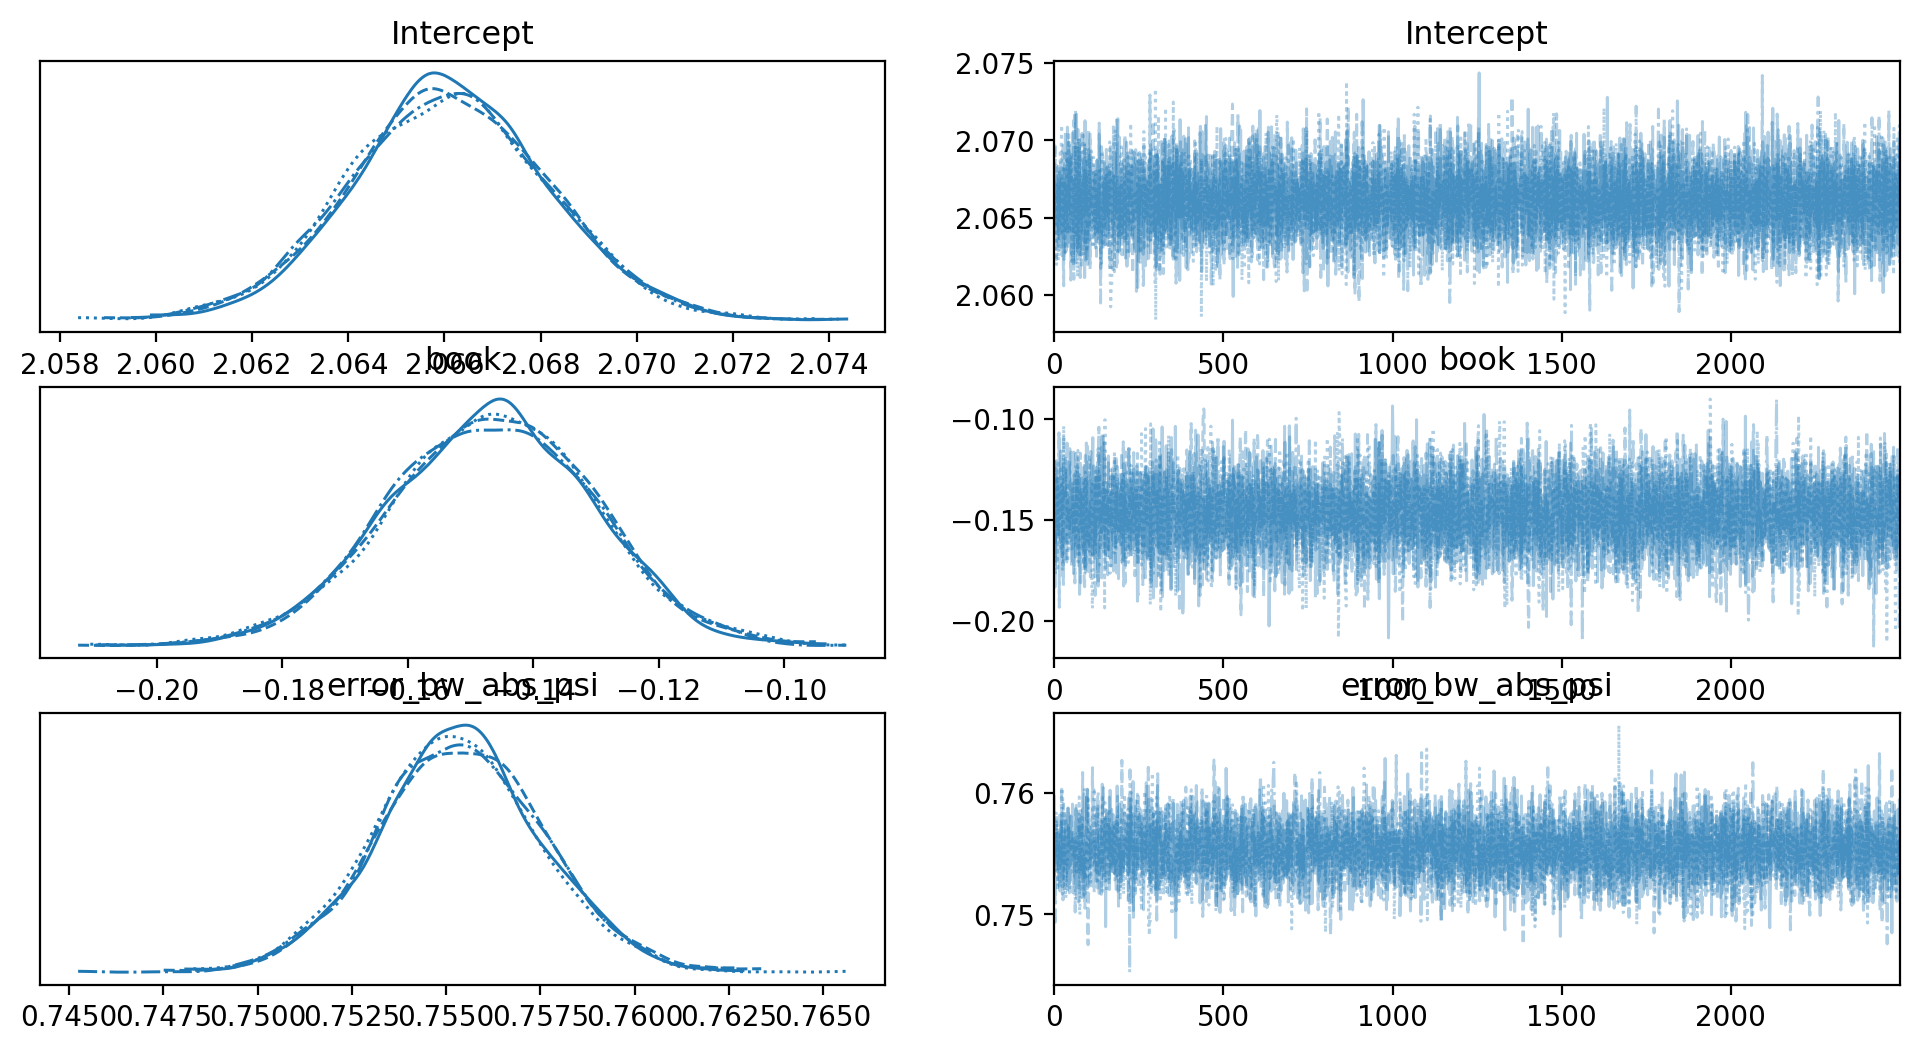

In [137]:
az.plot_trace(results);

In [124]:
az.summary(results_gaussian)

NameError: name 'results_gaussian' is not defined

In [125]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.060,0.002,2.056,2.064,0.0,0.0,13839.0,8072.0,1.0
bird[1],0.267,0.017,0.236,0.299,0.0,0.0,6774.0,6977.0,1.0
error_bw_abs_psi,0.755,0.002,0.751,0.759,0.0,0.0,6328.0,6437.0,1.0


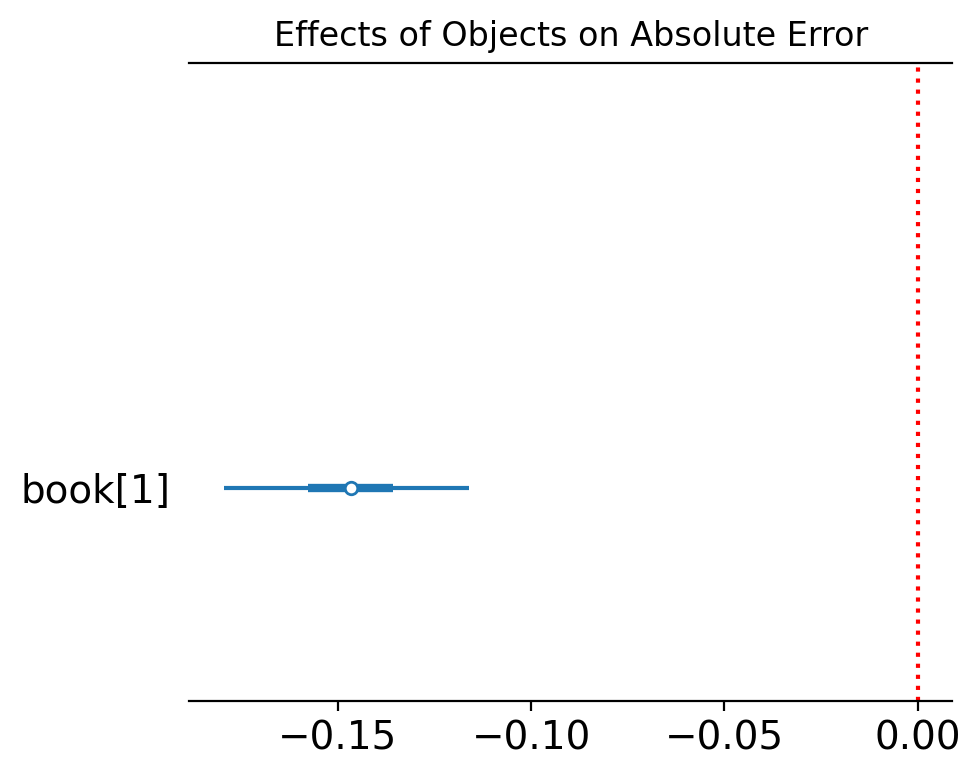

In [138]:
ax= az.plot_forest(
    results,
    combined=True,
    #filter_vars='like',
    #kind = 'ridgeplot',
    #var_names = selected_columns,
    var_names = ['book'],
    #var_names = ["bicycle", "boat", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"],
    figsize=(5, 4),
    hdi_prob=0.95,
);
ax[0].axvline(0, color="red", linestyle="dotted")
plt.title('Effects of Objects on Absolute Error')
plt.tight_layout()
plt.savefig('figures/effects_ZIP.png', dpi=300)

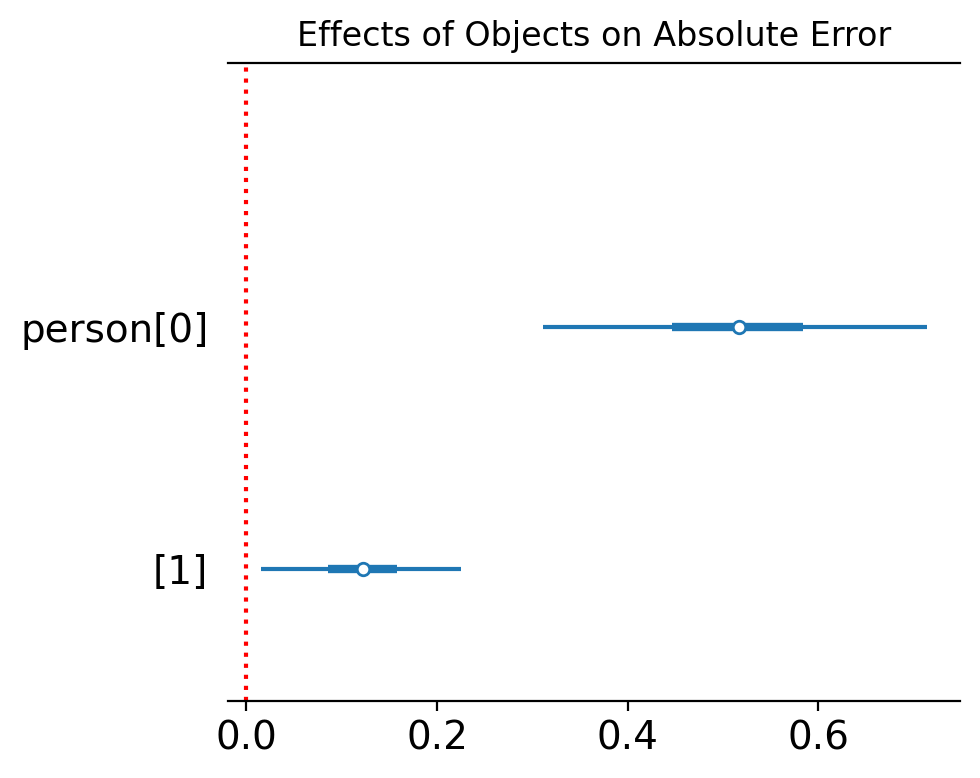

In [42]:
ax= az.plot_forest(
    results_gaussian,
    combined=True,
    #filter_vars='like',
    #kind = 'ridgeplot',
    #var_names = selected_columns,
    var_names = ['person'],
    #var_names = ["bicycle", "boat", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"],
    figsize=(5, 4),
    hdi_prob=0.95,
);
ax[0].axvline(0, color="red", linestyle="dotted")
plt.title('Effects of Objects on Absolute Error')
plt.tight_layout()
plt.savefig('figures/effects_ZIP.png', dpi=300)

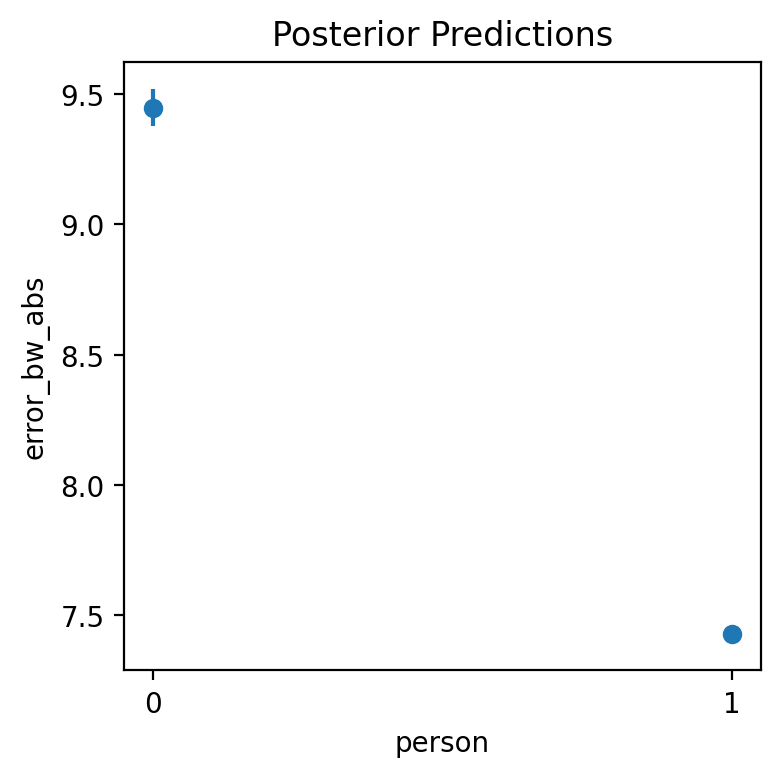

In [37]:


fig, ax = plt.subplots(figsize=(4, 4))
plot_cap(model, results, ["person"], ax=ax);
plt.title('Posterior Predictions')
plt.tight_layout()
plt.savefig('figures/predictions_ZIP.png', dpi=300)

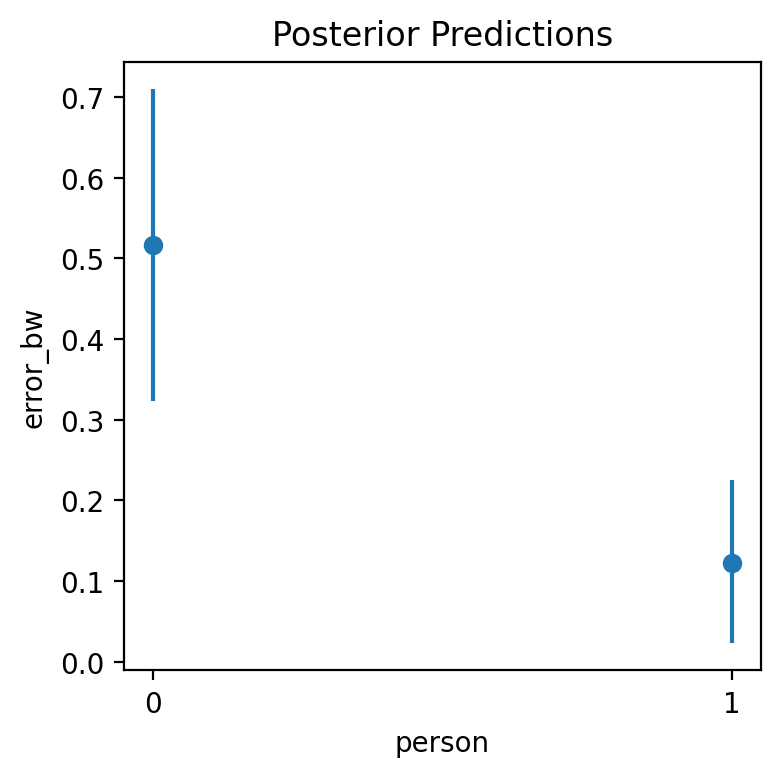

In [43]:


fig, ax = plt.subplots(figsize=(4, 4))
plot_cap(model_gaussian, results_gaussian, ["person"], ax=ax);
plt.title('Posterior Predictions')
plt.tight_layout()
plt.savefig('figures/predictions_ZIP.png', dpi=300)

In [37]:
df['n_people_s'] = (df['n_people']-df['n_people'].mean())/df['n_people'].std()

### Negative Binomial

In [46]:
model2 = bmb.Model(f'error_bw_abs ~ 1 + n_people_s*scene', 
                        df, 
                        family='negativebinomial')

In [ ]:
results2 = model2.fit(draws=2500, chains=4, inference_method='nuts_numpyro')



Compiling...
Compilation time =  0:00:06.359386
Sampling...


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [44]:
az.summary(results2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.781,0.007,1.768,1.793,0.0,0.0,10206.0,7342.0,1.0
n_people_s,-0.059,0.006,-0.071,-0.048,0.0,0.0,10599.0,8090.0,1.0
error_bw_abs_alpha,0.631,0.005,0.620,0.640,0.0,0.0,9337.0,7428.0,1.0


In [40]:
ax= az.plot_forest(
    results2,
    combined=True,
    #filter_vars='like',
    #kind = 'ridgeplot',
    #var_names = selected_columns,
    var_names = ['n_people'],
    #var_names = ["bicycle", "boat", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"],
    figsize=(5, 4),
    hdi_prob=0.95,
);
ax[0].axvline(0, color="red", linestyle="dotted")
plt.title('Effects of Objects on Absolute Error')
plt.tight_layout()
plt.savefig('figures/effects_negbinomial.png', dpi=300)

KeyError: 'var names: "[\'n_people\'] are not present" in dataset'

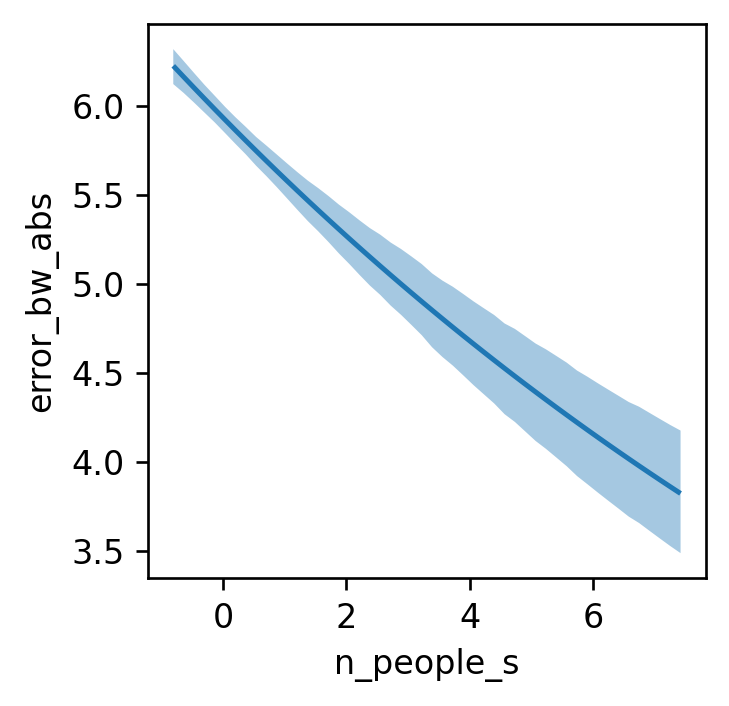

In [45]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=120)
bmb.interpret.plot_predictions(model2, results2, conditional=["n_people_s"], average_by='scene', ax=ax);

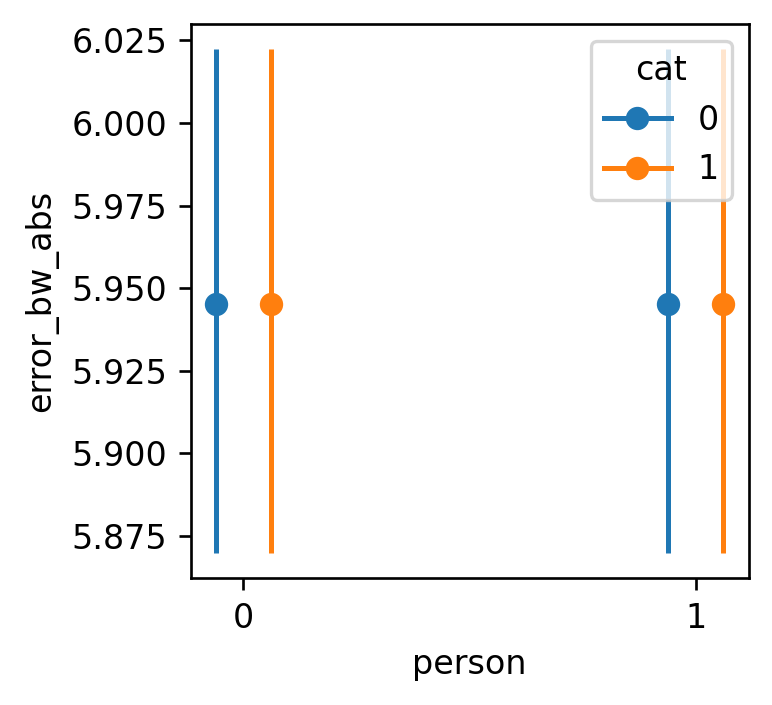

In [26]:
az.summary(results2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.970,0.015,1.943,1.997,0.000,0.000,24530.0,7633.0,1.0
bicycle[1],0.091,0.032,0.031,0.149,0.000,0.000,22669.0,8112.0,1.0
boat[1],0.123,0.042,0.043,0.203,0.000,0.000,23948.0,7308.0,1.0
bus[1],-0.075,0.073,-0.214,0.061,0.000,0.001,27599.0,7501.0,1.0
car[1],-0.057,0.024,-0.103,-0.011,0.000,0.000,20184.0,8072.0,1.0
motorcycle[1],0.102,0.082,-0.044,0.261,0.001,0.001,25109.0,7664.0,1.0
train[1],0.017,0.088,-0.143,0.184,0.001,0.001,23921.0,7159.0,1.0
truck[1],0.033,0.039,-0.040,0.107,0.000,0.000,21833.0,7222.0,1.0
bird[1],0.239,0.065,0.118,0.358,0.000,0.000,24676.0,7503.0,1.0
cat[1],-0.083,0.094,-0.257,0.099,0.001,0.001,22728.0,7926.0,1.0


In [57]:
import bambi as bmb

In [52]:
bambi.interpret

NameError: name 'bambi' is not defined

In [54]:
bmb.interpret

AttributeError: module 'bambi' has no attribute 'interpret'

In [56]:
!python -V

Python 3.10.9


In [29]:
from bambi.plots import plot_cap

ModuleNotFoundError: No module named 'bambi.plots'